# Financial Econometrics I: Homework 2
Jan Kubal & Matyáš Mattanelli

## Problem 1
### Loading data

We randomly selected 100 tickers out of the provided set using the sample() function without replacement. The SIS number of Matyáš served as the seed number. Then, we downloaded data for selected tickers from Yahoo Finance using the functionality of quantmod package and restricting the time range to the one specified in the assignment.

In [ ]:
#Loading necessary packages
suppressPackageStartupMessages({
library(quantmod)
library(rugarch)
library(tseries)
library(forecast)
})

In [3]:
#Loading the file containing the symbols
symbols2 <- read.csv("symbols2.csv")

#Generating 100 random numbers
set.seed(48983854) #random seed using the SIS number
indices <- sort(sample(1:377, 100, replace = F)) #geting sample, sorting from lowest to highest

#Extracting the tickers
tickers <- symbols2$Symbol[indices]

#Downloading the data for each ticker
tickers_data <- vector("list", length(tickers)) #Empty list for the data
options("getSymbols.warning4.0" = FALSE) #To suppress an annoying message
for (i in 1:length(tickers)) {
    tickers_data[[i]] <- getSymbols(tickers[i], src = "yahoo", auto.assign = F, from = "2019-01-01", to = "2022-01-01")
}

Warning message:
"BMS contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."


Further, we work only with the closing prices adjusted for splits and dividends (and/or capital gain distributions). This variable is (in case of yahoo finance) standardly located in the sixth column but, for completness, we include a check of this in the next cell.

In [4]:
#Check that the adjusted closing price is in the sixth column
sixth_cols <- vector("character", length(tickers_data))
is_adjusted <- vector("character", length(tickers_data))

for(i in 1:length(tickers_data)) {
 sixth_cols[i] <- names(tickers_data[[i]])[6]
}

for(i in 1:length(tickers_data)) {
 is_adjusted[i] <- substr(sixth_cols[i],  nchar(sixth_cols[i])-nchar("Adjusted")+1, nchar(sixth_cols[i])) #selecting only last eight characters of each column name
}

sum(is_adjusted == "Adjusted") #If we get here sum of 100, we got all the adjusted closing prices in the sixth column and can continue with the analysis

[1] 100

In the subsequent step, we merge the acquired data into a single xts object. This will facilitate and expedite the future calculations. In addition, we preserve the whole time range and gain better control over the missing values.

In [5]:
#Merging into a single xts object
adjusted_prices <- merge.xts(tickers_data[[1]][, 6], tickers_data[[2]][, 6]) #Initial merge
for (i in 3:100) { #Loop to merge all 100 tickers
    adjusted_prices <- merge.xts(adjusted_prices,tickers_data[[i]][, 6])
}

### 1) Log-returns

Bellow, we compute the logarithmic returns on the stocks of our interest. This is done using the formula for logarithmic returns: $log(R_t) = log(\frac{P_t - P_{t-1}}{P_{t-1}}) = log(\frac{P_t}{P{t-1}}-\frac{P_{t-1}}{P{t-1}}) = log(\frac{P_t}{P{t-1}}) - log(1) = log(P_t) - log(P_{t-1})$.

In [6]:
#Log-returns
log_returns <- log(adjusted_prices) - log(lag(adjusted_prices)) #Given the nature of the xts object, the operation is performed on each column separately

For illustration, we plot all of the resulting log-returns below. The first glimpse suggests that the series may be mean-stationary but the variance appears to vary accross time for most of the tickers.

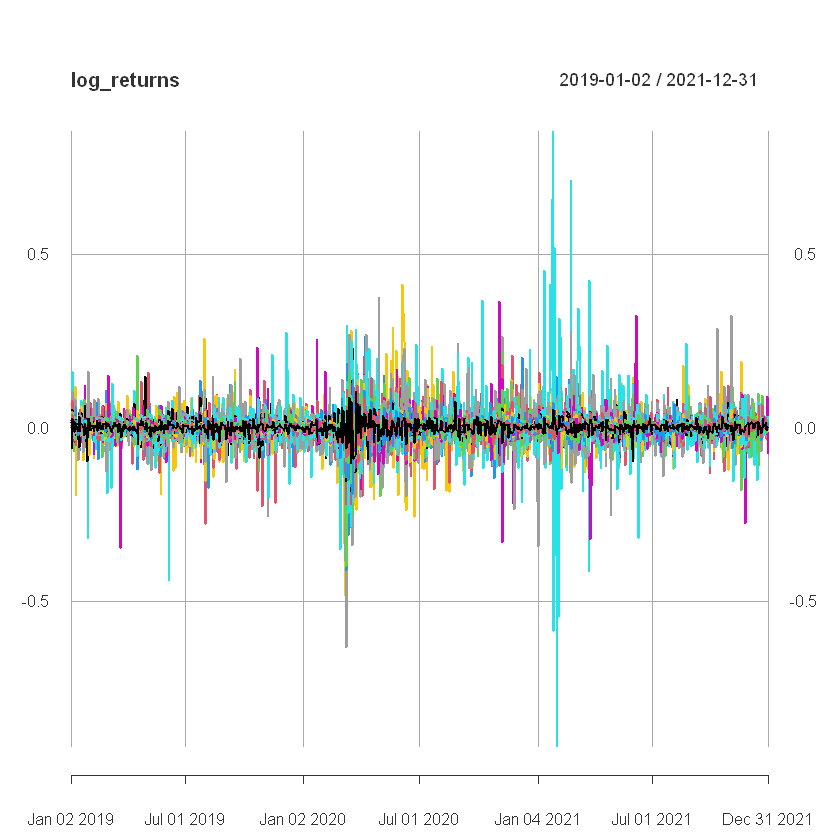

In [7]:
#Plotting the log-returns
plot(log_returns)

### 2) Estimating GARCH(1,1) models

In this section, we estimate 100 GARCH(1,1) models (one for each stock). Since the ARMA order is not specified and it would be tedious to individually inspect each firm, we assume ARMA(0,0). The GARCHes estimated are of standard form:

$
a_t = \sigma_t\epsilon_t \\
\sigma^2_t = \alpha_0 + \alpha_1a^2_{t-1} + \beta_1\sigma^2_{t-1}
$ where $(\alpha_1 + \beta_1) < 1$.

 For the estimation, we use functions from the ugarch package.

In [8]:
#Estimating GARCH(1,1) models and saving fitted objects in list
garch_list <- vector("list", length(tickers_data)) #empty list to be filled with fitted-model objects

for(i in 1:length(tickers_data)){
    garch_spec <- ugarchspec(mean.model = list(armaOrder = c(0, 0)), variance.model = list(garchOrder = c(1, 1)))
    garch_fit <- ugarchfit(garch_spec, na.omit(log_returns[, i])) #NAs removed since the function cannot handle them
    garch_list[[i]] <- garch_fit
}

### 3) Extracting and plotting alphas and betas

In this section, we extract the estimated parameters from fitted models and plot their histograms.

In [10]:
#Initializing an empty dataframe
coef_df <- data.frame(Firm = tickers, 
                    alphas = rep(NA, length(tickers_data)), 
                    betas = rep(NA, length(tickers_data)), 
                    ab_sum = rep(NA, length(tickers_data)))

#Filling the dataframe with the estimated aplphas, betas, and their sums
for(i in 1:length(tickers_data)){
    coef_df$alphas[i] <- as.numeric(coef(garch_list[[i]])[3])
    coef_df$betas[i] <- as.numeric(coef(garch_list[[i]])[4])
    coef_df$ab_sum[i] <- as.numeric(coef(garch_list[[i]])[3]) + as.numeric(coef(garch_list[[i]])[4])
}                    

Bellow, histograms are displayed. From the definition of the GARCH(1,1) model, we know that $\alpha + \beta < 1$. Keeping this information in mind, we can observe that estimated alphas attain relatively small values (most frequently between 0.1 and 0.2), while betas relatively large values (concentrated around 0.8). 

In the GARCH model, $\alpha$ represents the effect of the excess squared return $a^2$ in period $t-1$ on the volatility $\sigma^2$ in period $t$, and $\beta$ represents the effect of $\sigma^2_{t-1}$ on $\sigma^2_t$. Therefore, based on the models estimated we could assume that for most stocks, the effect of past excess returns on the volatility will be present, but not very strong, while the effect of volatility on itself will be dominant. This also supports empirically observed volatility clustering, according to which the large (small) price changes tends to be followed by large (small) price changes as well. 

From the histogram of $(\alpha+\beta)$ values, we can see that for the majority of fitted models the sum is close to 1 (mostly concentrated around 0.95). The condition $(\alpha_1 + \beta_1) < 1$ ensures that conditional variance of $a_t$, $\sigma^2_t$, does not diverge, but converge to unconditional variance $\alpha_0$ in infinity. Therefore, as the sum tends to be close to 1, we can assume that $\sigma^2_t$ will convergence only slowly, past mean corrected returns $a^2_{t-1}$ will play an important role, and/or the effect of $\sigma^2_{t-1}$ (variance clustering effect) will be prominent.

There are also outliers in the vectors of alphas and betas, but these are explored in the next section. These cause the distribution of alphas to be righ-skewed while the distribution of betas and the sums to be left-skewed.

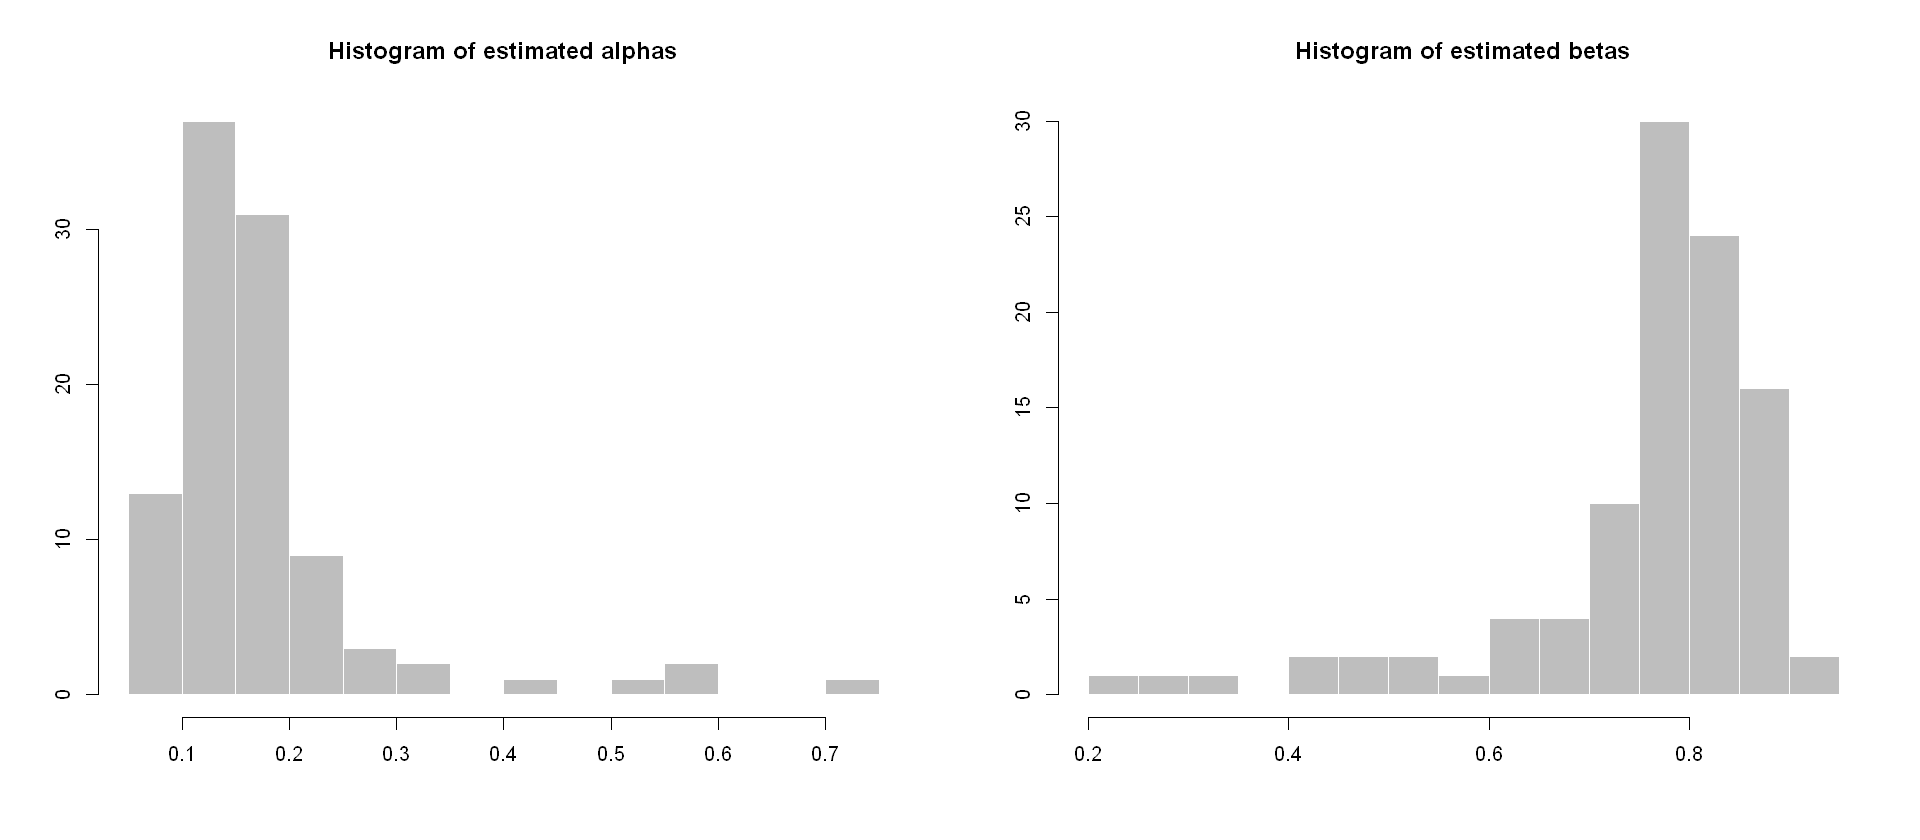

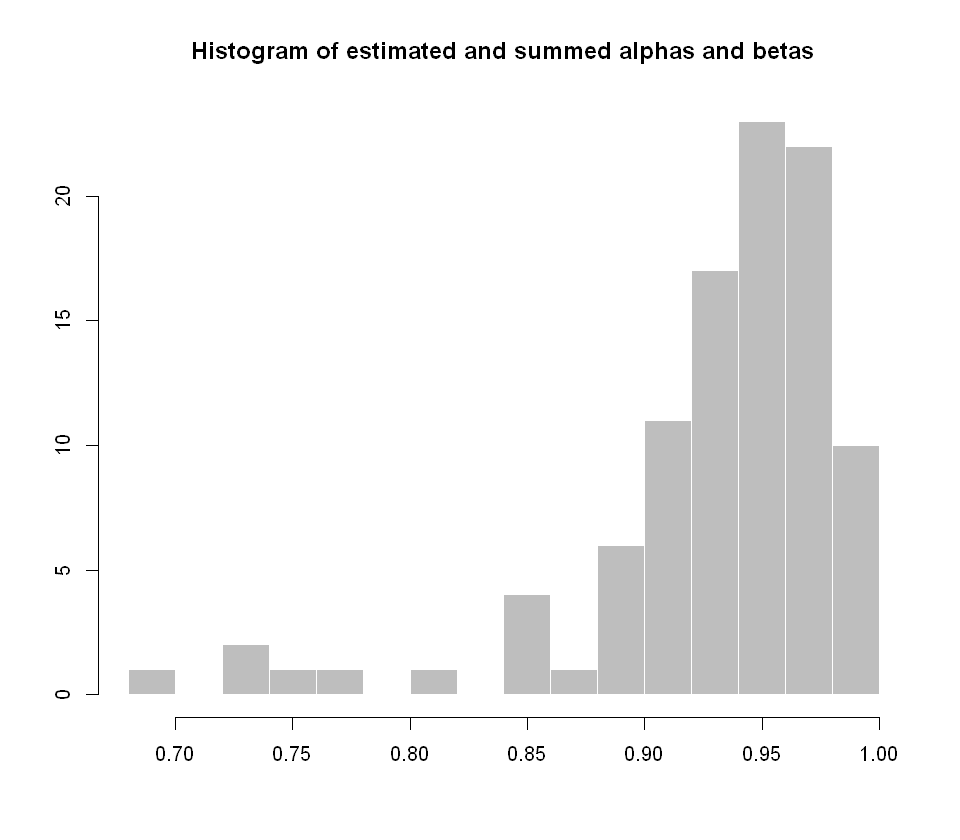

In [11]:
#ploting the crossection of coefficients
options(repr.plot.width = 16, repr.plot.height = 7)
par(mfrow = c(1, 2))
hist(coef_df$alphas, breaks = "FD", border = F, col = "grey", main = "Histogram of estimated alphas", xlab = "", ylab = "")
hist(coef_df$betas, breaks = "FD", border = F, col = "grey", main = "Histogram of estimated betas", xlab = "", ylab = "")
options(repr.plot.width = 8, repr.plot.height = 7)
par(mfrow = c(1, 1))
hist(coef_df$ab_sum, breaks = "FD", border = F, col = "grey", main = "Histogram of estimated and summed alphas and betas", xlab = "", ylab = "")

### 4) Maximum estimated coefficients

Following directly from the pevious section, here we show smallest and largest values of estimated parameters.

In [13]:
#alpha
m_a <- max(coef_df$alphas)
m_a_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_a, coef_df$alphas)]]
m_a_min <- min(coef_df$alphas)
m_a_name_min <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_a_min, coef_df$alphas)]]

#beta
m_b <- max(coef_df$betas)
m_b_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_b, coef_df$betas)]]
m_b_min <- min(coef_df$betas)
m_b_name_min <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_b_min, coef_df$betas)]]

#sums
m_ab <- max(coef_df$ab_sum)
m_ab_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_ab, coef_df$ab_sum)]]
m_ab_min <- min(coef_df$ab_sum)
m_ab_name_min <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_ab_min, coef_df$ab_sum)]]

#alpha
print(paste("Maximum estimated alpha:", m_a, "for firm", m_a_name))
print(paste("Minimum estimated alpha:", m_a_min, "for firm", m_a_name_min))

#beta
print(paste("Maximum estimated beta:", m_b, "for firm", m_b_name))
print(paste("Minimum estimated beta:", m_b_min, "for firm", m_b_name_min))

#sums
print(paste("Maximum estimated sum:", m_ab, "for firm", m_ab_name))
print(paste("Minimum estimated sum:", m_ab_min, "for firm", m_ab_name_min))

[1] "Maximum estimated alpha: 0.730009074624895 for firm Hasbro Inc."
[1] "Minimum estimated alpha: 0.0575179632025146 for firm Newmont Mining Corp. (Hldg. Co.)"
[1] "Maximum estimated beta: 0.916040620200184 for firm Ryder System"
[1] "Minimum estimated beta: 0.231085216136158 for firm Hasbro Inc."
[1] "Maximum estimated sum: 0.998999981745974 for firm Host Hotels & Resorts"
[1] "Minimum estimated sum: 0.698996187531329 for firm Intel Corp."


Interpretation of maximal and minimal values of estimated coefficients stems from their properties described above. 

* In the case of Hasbro Inc. (largest alpha and smallest beta), we can assume that variance of log-returns on the firm's stock will be heavily affected by past mean-corrected returns, while the volatility clustering effect will be weak.

* For the Newmont Mining Corp. (smallest alpha), we could expect the variance $\sigma^2_t$ to be only very weakly dependent on the past returns.

* Rider Systems' return volatility will likely suffer of strong volatility clustering effect, as values of $\sigma^2_t$ will probably be strongly affected by $\sigma^2_{t-1}$ (largest beta).

* For the Host Hotels & Resorts (largest sum of alpha and beta), we can assume the volatility converge to unconditional volatility very slowly, the effect of past returns and volatility clustering being strong.

* On the other hand, in case of Intel Corp. (smallest sum), the $\sigma^2_t$ will likely converge to $\alpha_0$, and the effect of $a_{t-1}$ and volatility clustering will be weak.

### 5) Estimated volatility averaged 

Here, we extract the estimated volatilities from the GARCH(1,1) models and then calculate the median, 5%, and 95% quantiles for each day.

In [12]:
#We extract the volatility for the first stock and then merge it with the second one. Subsequently, we loop through the rest
volatilities <- merge.xts(sigma(garch_list[[1]]), sigma(garch_list[[2]]))
for (iter in 3:length(garch_list)) {
    volatilities <- merge.xts(volatilities, sigma(garch_list[[iter]]))
}

Now, we can calculate the quantiles.

In [14]:
#Five percent
five_percent <- apply.daily(volatilities, function(x) quantile(c(x), probs = 0.05, na.rm = TRUE))
#Median
medians <- apply.daily(volatilities, function(x) quantile(c(x), probs = 0.5, na.rm = TRUE))
#Ninety-five percent
ninety_five_percent <- apply.daily(volatilities, function(x) quantile(c(x), probs = 0.95, na.rm = TRUE))

And finally, we plot the estimated "market" volatility. The median volatility is shown in black while the 5% and 95% quantiles in red. The resulting interval delimited by the 5% and 95% qunatiles is where we would expect the volatility of majority of firms to be present.

To comment on the volatility values themselves, we can observe that at the first quarter of 2020, there was an extreme spike in market volatility very likely caused by the break-out of the Covid-19. Since then, variance slowly returned to its pre-covid values. We can also observe volatility clustering from the plot, since an increased volatility is likely to be again followed by increased volatility.

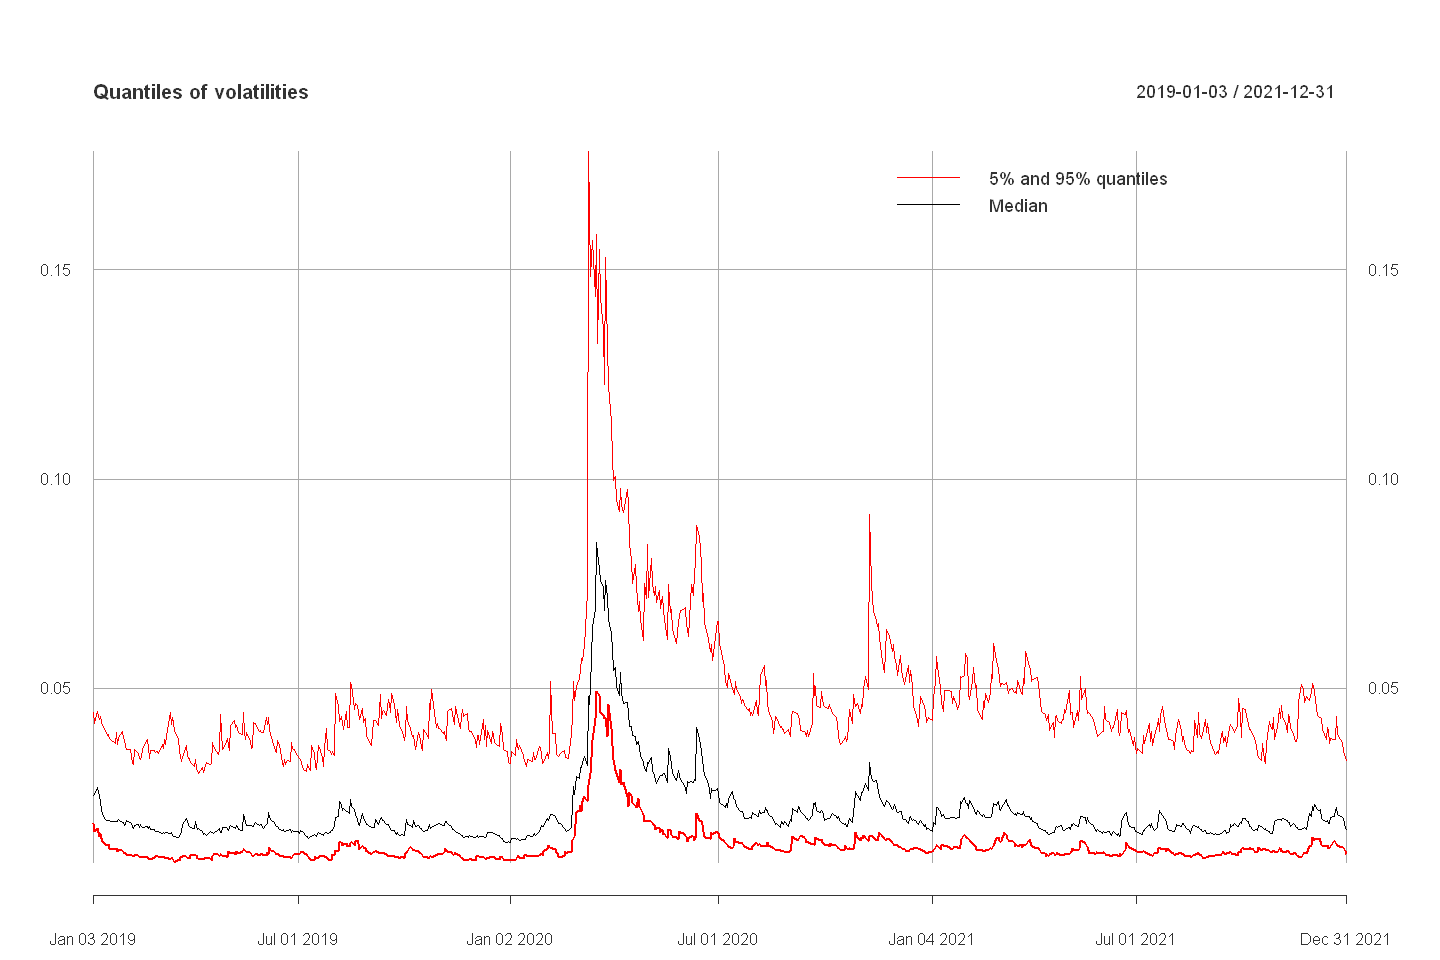

In [17]:
#Plotting
options(repr.plot.width = 12, repr.plot.height = 8)
plot_holder <- plot(five_percent, col = "red", ylim = c(min(five_percent, medians, ninety_five_percent),max(five_percent, medians, ninety_five_percent)), main = "Quantiles of volatilities")
plot_holder <- lines(medians, col = "black")
plot_holder <- lines(ninety_five_percent, col = "red")
plot_holder <- addLegend("topright", on=1, legend.names = c("5% and 95% quantiles", "Median"), col=c("red", "black"), lty=c(1, 1))
plot_holder

### Problem 2

Firstly, we will compute the means from the logarithmic returns obtained above. For each day, we will average all the observations available from the 100 stocks.

In [18]:
#Computing the means
log_returns_means <- apply.daily(log_returns, function(x) mean(c(x), na.rm = TRUE))

Next, we quickly inspect the summary. We can see that the mean is very close to zero and the first and third quartiles have a similar distance from the mean. However, the histogram hints that the tails are quite heavy and the kurtosis is also likely higher than in a normal distribution. Moreover, the line plot indicates that the series might have a constant mean, however, we need to test it emphirically. With this in mind, we proceed with the analysis.

     Index            log_returns_means   
 Min.   :2019-01-02   Min.   :-0.1367964  
 1st Qu.:2019-10-02   1st Qu.:-0.0060408  
 Median :2020-07-02   Median : 0.0011411  
 Mean   :2020-07-02   Mean   : 0.0006761  
 3rd Qu.:2021-04-05   3rd Qu.: 0.0081388  
 Max.   :2021-12-31   Max.   : 0.1169785  
                      NA's   :1           

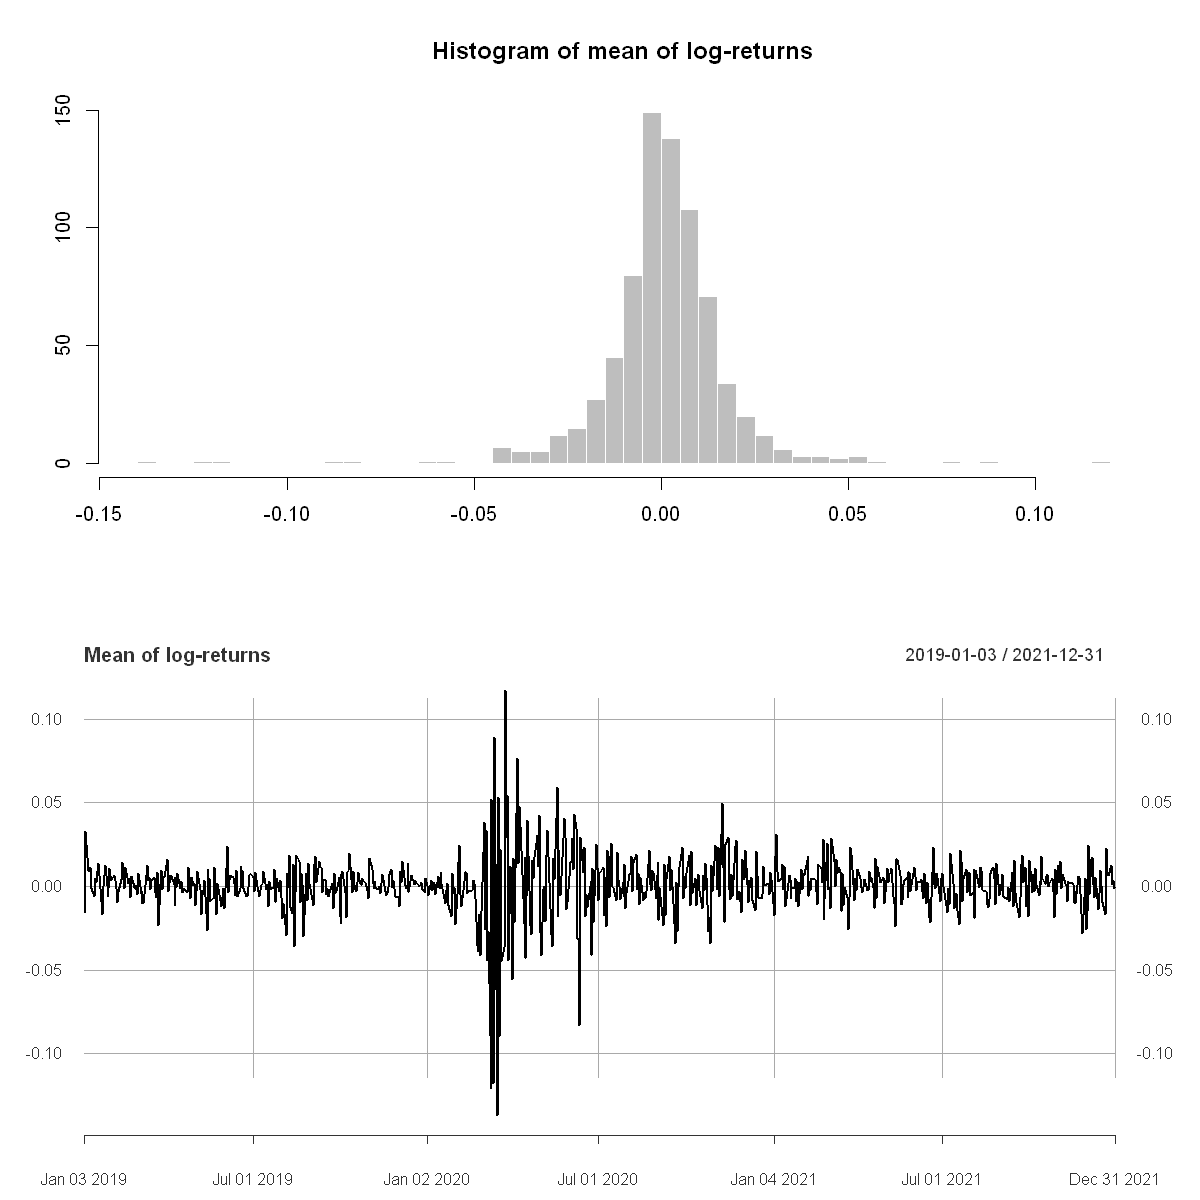

In [19]:
summary(log_returns_means)
log_returns_means <- na.omit(log_returns_means) #Dropping one missing observation (it is the first one for which one the return is obviously unavailable)
par(mfrow = c(2,1))
options(repr.plot.width = 10, repr.plot.height = 10)
hist(log_returns_means, border = F, xlab = "", ylab = "", main = "Histogram of mean of log-returns", col = "grey", breaks = "FD")
plot(log_returns_means, main = "Mean of log-returns")

As discussed above, we need to investigate the weak (covariance) stationarity of the series. Therefore, we will perform the Augmented Dicker-Fulley test with the null hypothesis that the series contains a unit root. As can be seen from the results, we strongly reject the null hypothesis in favor of stationarity. Since the series is already differenced, this does not come as a surprise. However, we needed to make sure whether the original series was not integrated of order higher than one.

In [20]:
#ADF test
adf.test(log_returns_means)

Warning message in adf.test(log_returns_means):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  log_returns_means
Dickey-Fuller = -7.3875, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


In the following step we will inspect the autocorrelation (ACF) and partial autocorrelation function (PACF) in order to select the appropriate model for the series. The former shows the unconditional correlation between the series and its lags while the latter runs a linear regression accounting for all the lags prior to the one of our interest.

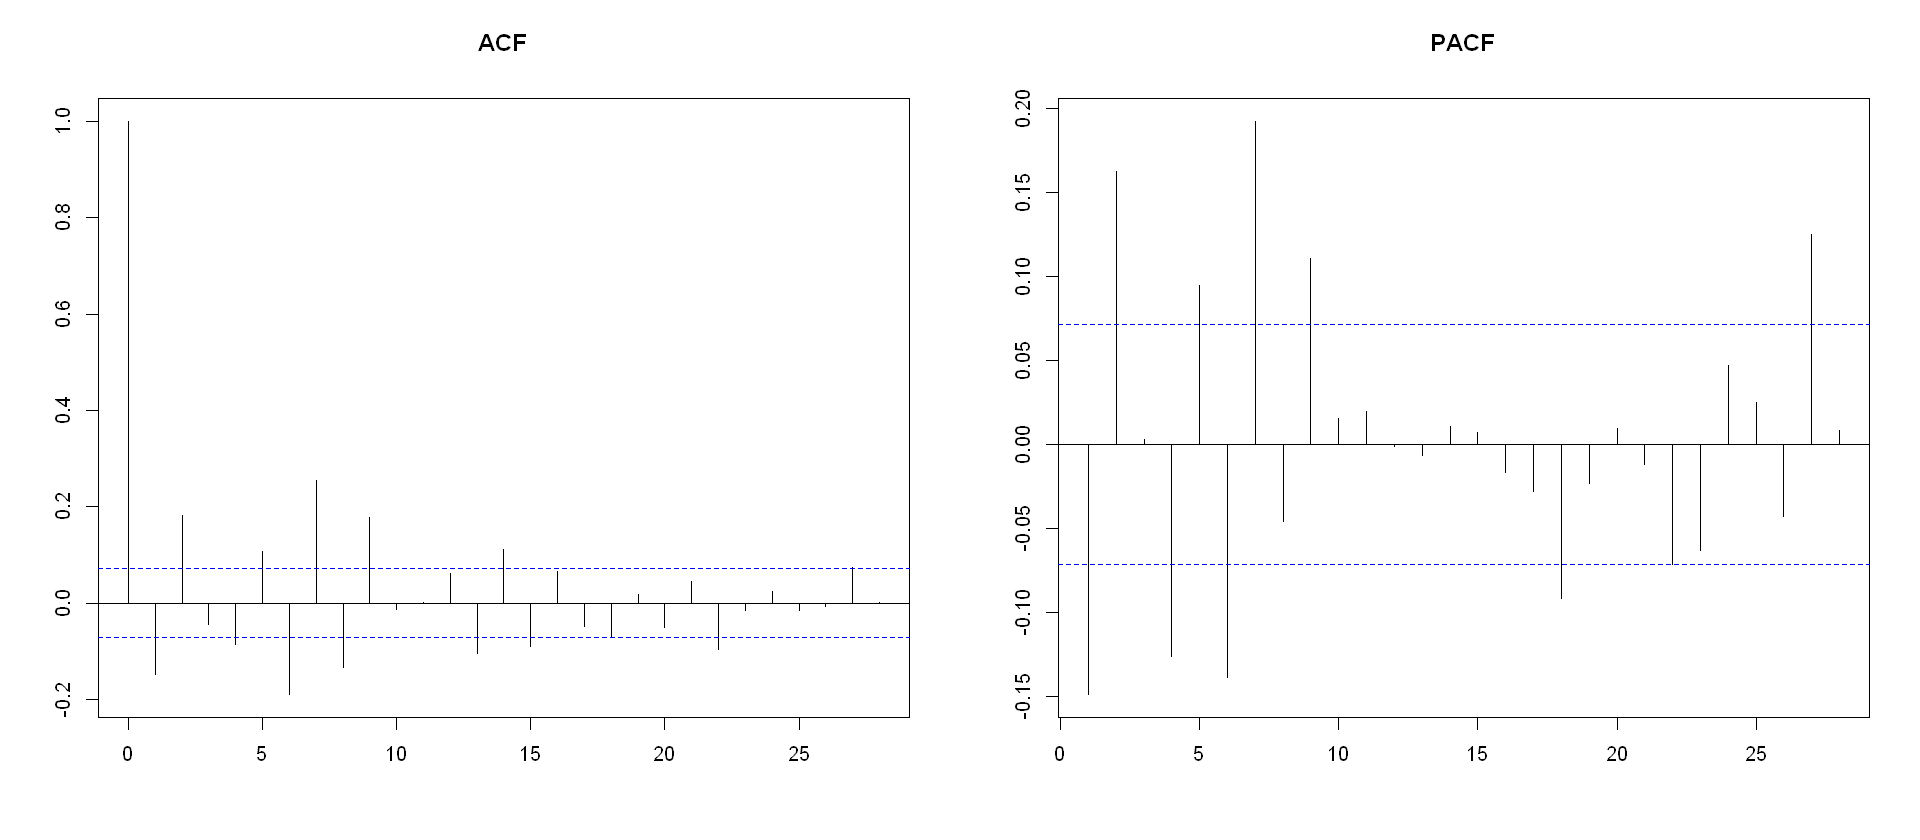

In [21]:
#ACF and PACF
par(mfrow=c(1,2))
options(repr.plot.width = 16, repr.plot.height = 7)
acf(log_returns_means, xlab = "", ylab = "", main = "ACF")
pacf(log_returns_means, xlab = "", ylab = "", main = "PACF")

As can be seen, there is no obvious sharp drop in neither of the plots which would point us in the direction of either separate AR process or separate MA process. Therefore, since the correlation between the lags dissipates only slowly in both functions, it will likely be some combination of the two processes. According to both the ACF and the PACF, there appear to be some dependencies up to the nineth lag. In addition, the signs of the correlations seem to be alternating. Since we want the model to be as simple as possible (no high orders), we will start with estimating ARMA(1,1) and inspecting how well we are doing at removing the dependencies. Then, we will adjust the model accordingly.

In [22]:
#ARMA(1,1)
arma11 <- Arima(log_returns_means, order = c(1, 0, 1))
summary(arma11)

Series: log_returns_means 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
          ar1     ma1   mean
      -0.5166  0.3561  7e-04
s.e.   0.0864  0.0896  6e-04

sigma^2 = 0.0003054:  log likelihood = 1988.23
AIC=-3968.46   AICc=-3968.41   BIC=-3949.95

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 1.381272e-06 0.01744154 0.01085967 59.20155 180.2563 0.6790636
                   ACF1
Training set 0.03567189

A quick glimpse at the results reveals that both the autoregressive term and the moving average term are highly statistically significant. Furthermore, the sign of the AR term is negative which corresponds to the alternating correlations observed in the previous plot. The constant term is not statistically distinguishable from zero. Nevertheless, we need to assess the performance of the model. Firstly, we will, once again, take a look at ACF and PACF but this time of the model's residuals.

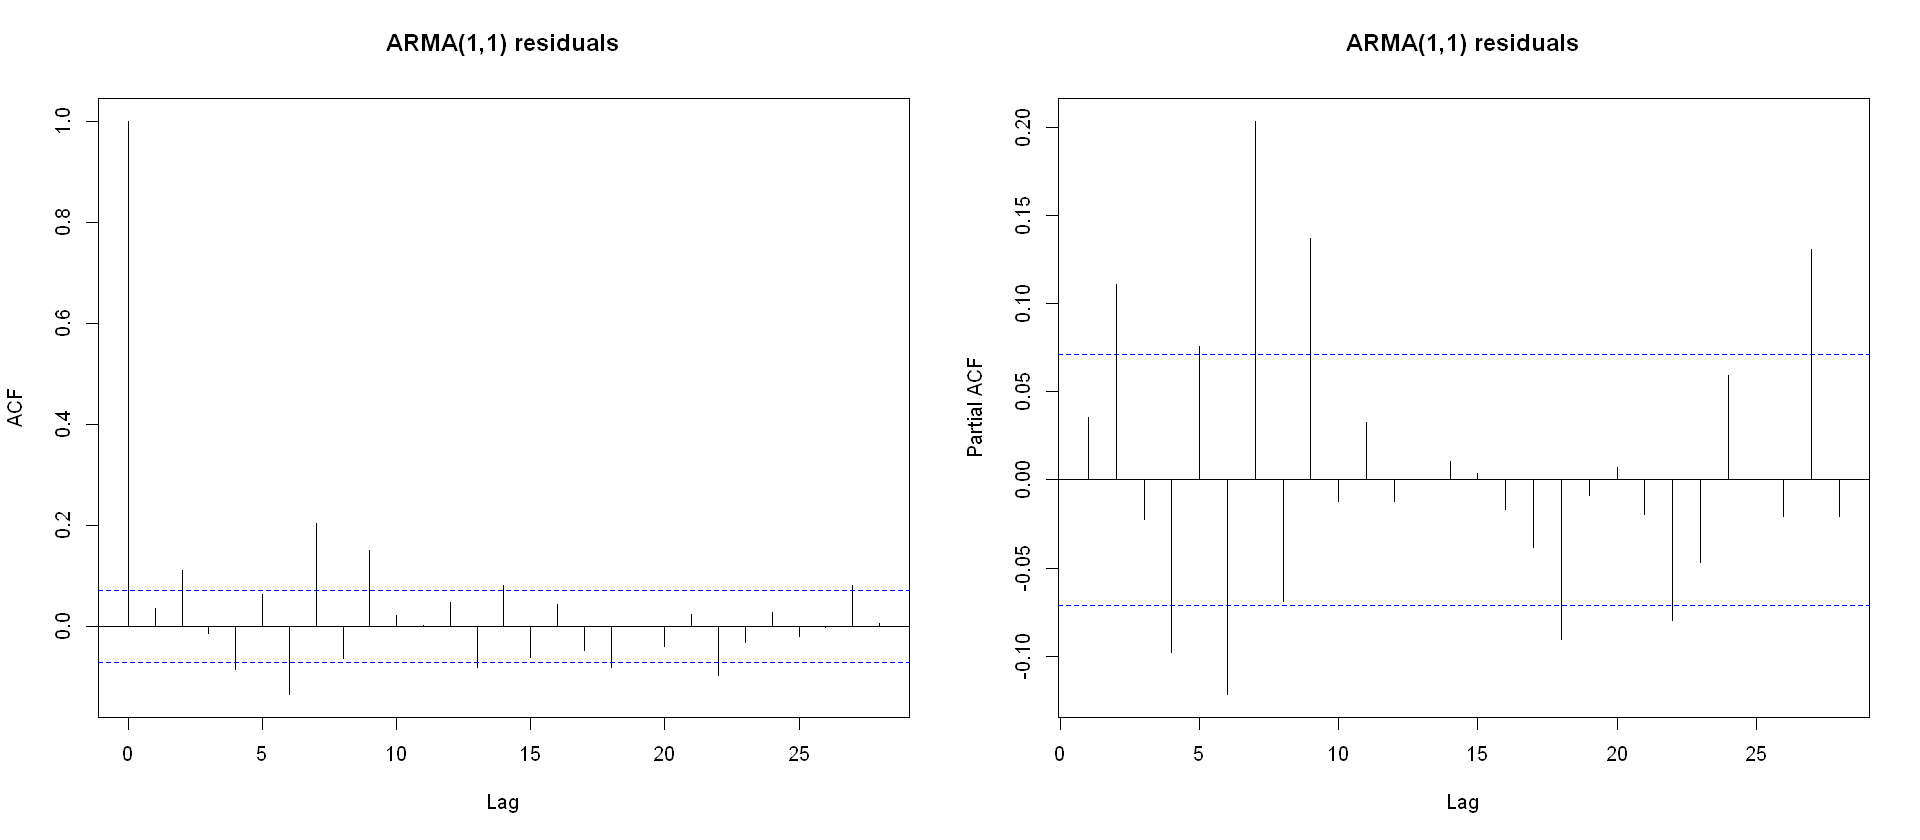

In [23]:
#ACF and PACF
par(mfrow=c(1,2))
options(repr.plot.width = 16, repr.plot.height = 7)
acf(arma11$residuals, main = "ARMA(1,1) residuals")
pacf(arma11$residuals, main = "ARMA(1,1) residuals")

As can be seen, we successfully removed some dependencies especially according to the ACF. However, there still appears to be many of them left. We can confirm that using the Ljung-Box test which tests the null hypothesis that the time series is independent.

In [24]:
#Ljung-Box test
for (lag_order in c(4, 8, 12)) {
    print(Box.test(arma11$residuals, type = "Ljung-Box", lag = lag_order))
}


	Box-Ljung test

data:  arma11$residuals
X-squared = 16.205, df = 4, p-value = 0.002756


	Box-Ljung test

data:  arma11$residuals
X-squared = 67.98, df = 8, p-value = 1.239e-11


	Box-Ljung test

data:  arma11$residuals
X-squared = 87.498, df = 12, p-value = 1.503e-13



The results suggests that there is still autocorrelation even at the fourth order since we reject the null of independence. Thereofore, we need to adjust the model accordingly. Given that the dependencies are more singificantly shown in PACF, we will try incresing the order of the moving average process. Thereofore, we will estimate ARMA(1,2).

In [25]:
#ARMA(1,2)
arma12 <- Arima(log_returns_means, order = c(1, 0, 2))
summary(arma12)

Series: log_returns_means 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
          ar1     ma1     ma2   mean
      -0.2712  0.1514  0.1735  7e-04
s.e.   0.1398  0.1379  0.0399  7e-04

sigma^2 = 0.0002997:  log likelihood = 1995.9
AIC=-3981.81   AICc=-3981.73   BIC=-3958.67

Training set error measures:
                        ME       RMSE        MAE       MPE     MAPE      MASE
Training set -5.096587e-06 0.01726478 0.01096103 -675.3376 948.6892 0.6854021
                     ACF1
Training set -0.002857977

As can be seen, the newly introduced term is highly statistically significant. Curiously, the first lag of the MA process is not significant anymore. Nevertheless, we can see the increase in performance already in the decreased values of the information criteria. We will inspect it further by taking a look at the ACF and PACF once again. 

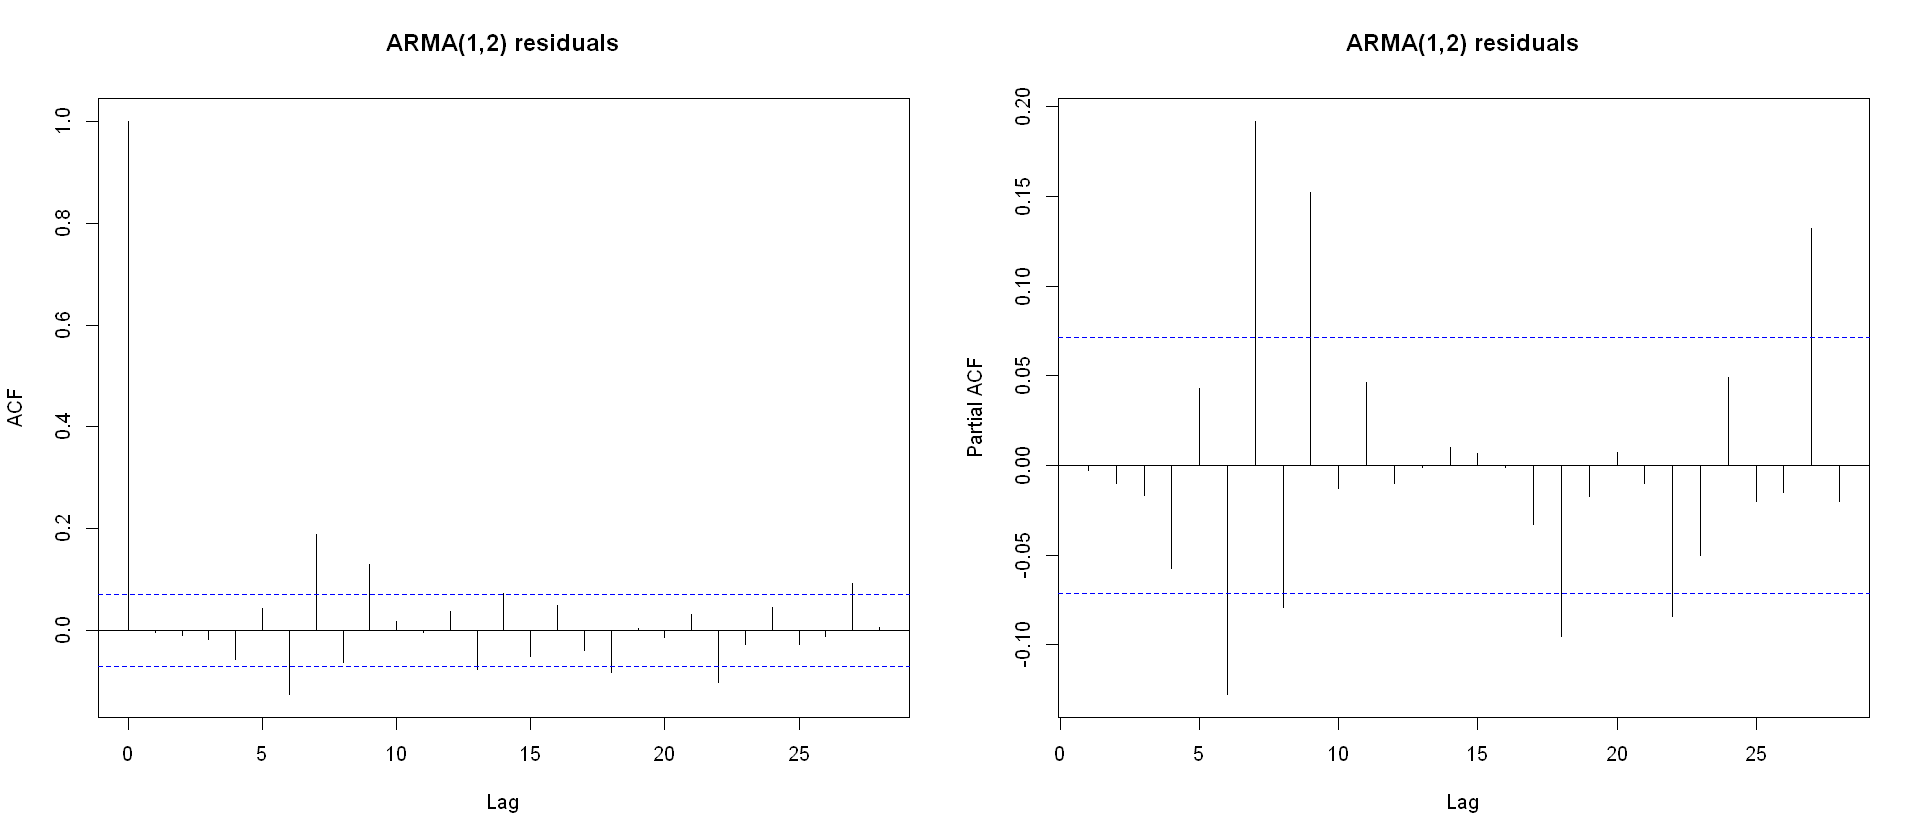

In [27]:
#ACF and PACF
par(mfrow=c(1,2))
options(repr.plot.width = 16, repr.plot.height = 7)
acf(arma12$residuals, main = "ARMA(1,2) residuals")
pacf(arma12$residuals, main = "ARMA(1,2) residuals")

The figures show that we are indeed doing a better job at removing the dependencies. Nevertheless, both functions still suggest some significant correlations in lags of the sixth and higher orders. Again, we will test this empirically.

In [28]:
#Ljung-Box test
for (lag_order in c(4, 8, 12)) {
    print(Box.test(arma12$residuals, type = "Ljung-Box", lag = lag_order))
}


	Box-Ljung test

data:  arma12$residuals
X-squared = 2.7808, df = 4, p-value = 0.5951


	Box-Ljung test

data:  arma12$residuals
X-squared = 46.546, df = 8, p-value = 1.871e-07


	Box-Ljung test

data:  arma12$residuals
X-squared = 60.592, df = 12, p-value = 1.76e-08



The results of the test mostly confirm our observations since there do not appear to be any autocorrelation of the fourth order but we reject the null in higher orders. Therefore, we need to keep looking for a better model. We will now try to estimate ARMA(2,2).

In [43]:
#ARMA(2,2)
arma22 <- Arima(log_returns_means, order = c(2, 0, 2))
summary(arma22)

Series: log_returns_means 
ARIMA(2,0,2) with non-zero mean 

Coefficients:
          ar1      ar2     ma1     ma2   mean
      -1.7254  -0.8823  1.5924  0.7231  7e-04
s.e.   0.0327   0.0328  0.0470  0.0455  6e-04

sigma^2 = 0.0002827:  log likelihood = 2018.26
AIC=-4024.53   AICc=-4024.42   BIC=-3996.76

Training set error measures:
                        ME       RMSE        MAE       MPE     MAPE      MASE
Training set -2.124371e-06 0.01675729 0.01082278 -330.1171 613.9334 0.6767573
                  ACF1
Training set 0.0807223

The output above presents quite satisfying results. All of the coefficients are very highly statistically significant and we can see the largest decline in the information criteria so far. The perfomance assessment follows.


	Box-Ljung test

data:  arma22$residuals
X-squared = 9.9982, df = 4, p-value = 0.04046


	Box-Ljung test

data:  arma22$residuals
X-squared = 18.245, df = 8, p-value = 0.01946


	Box-Ljung test

data:  arma22$residuals
X-squared = 26.286, df = 12, p-value = 0.009776



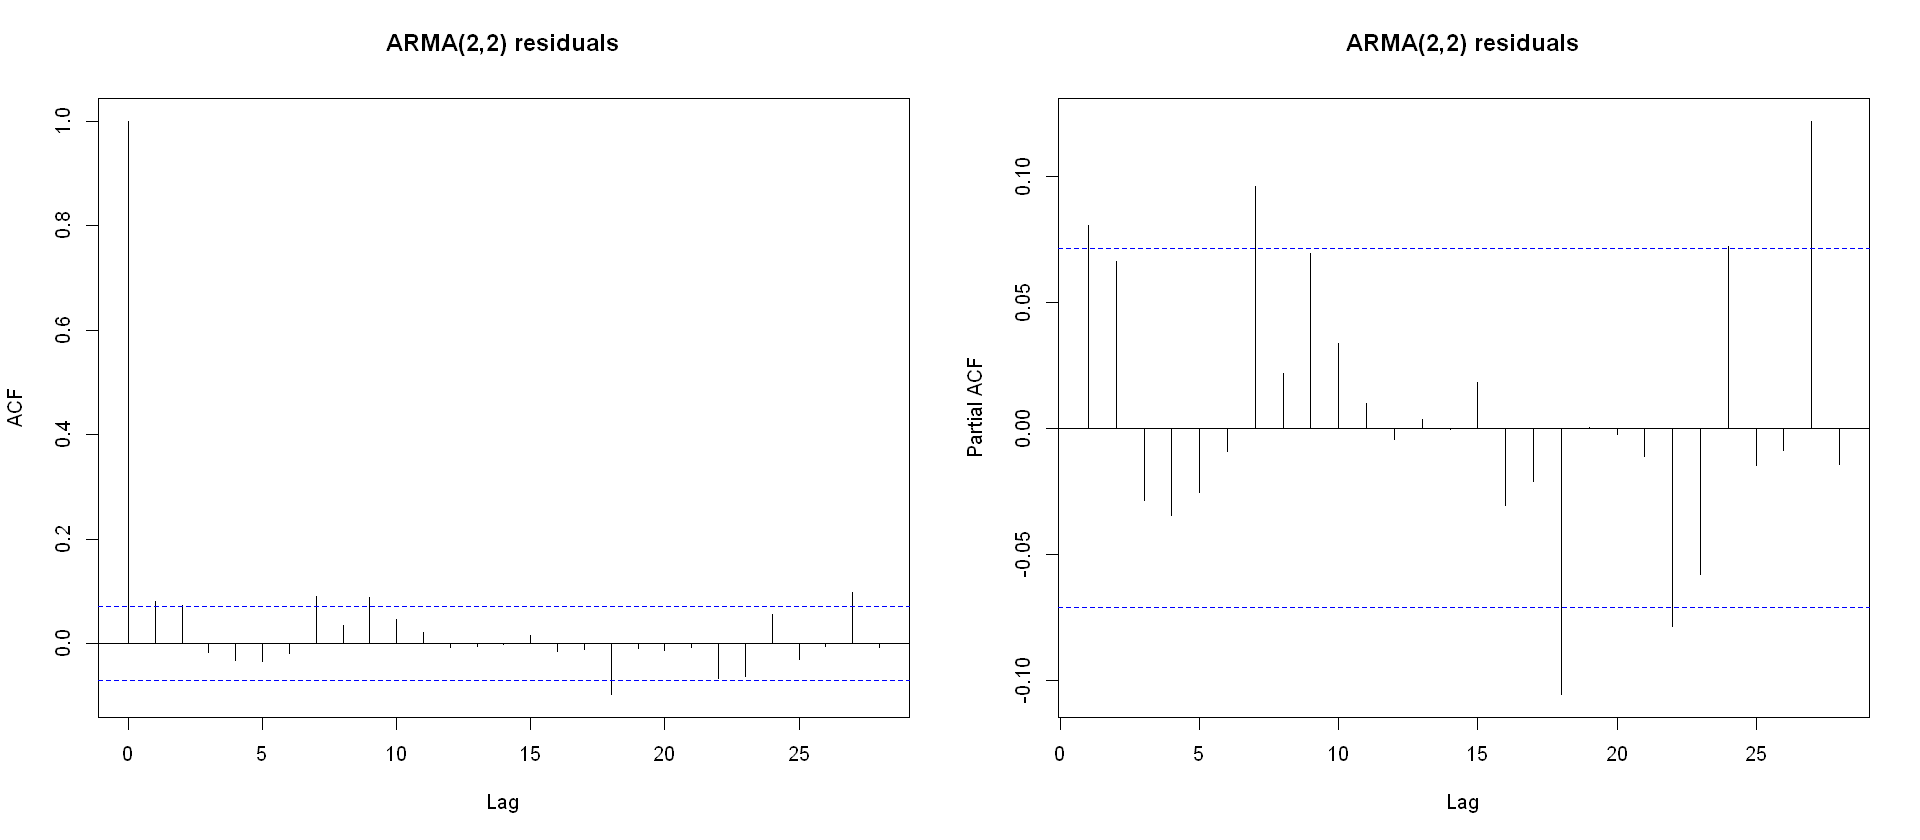

In [44]:
#ACF and PACF
par(mfrow=c(1,2))
options(repr.plot.width = 16, repr.plot.height = 7)
acf(arma22$residuals, main = "ARMA(2,2) residuals")
pacf(arma22$residuals, main = "ARMA(2,2) residuals")

#Ljung-Box test
for (lag_order in c(4, 8, 12)) {
    print(Box.test(arma22$residuals, type = "Ljung-Box", lag = lag_order))
}

The implications of the results above are mixed. On one hand, we can see that we reject the null of the Ljung-Box test even at the fourth order which suggests that we are doing a worse job than with the previous model. On the other hand, the ACF and PACF plots show that we have only a few dependencies left. At this point, we migh want to try to let the computer do the job and select the best model based on information criteria. We can then assess its performance and compare it to our models.

In [51]:
#Finding the best model based on the information criteria
for (inf_crit in c("aic","aicc","bic")) {
    auto_model <- auto.arima(log_returns_means, stationary = T, ic = inf_crit) 
    print(paste(inf_crit, ": ", "ARMA(", auto_model$arma[1], ",", auto_model$arma[2], ")", sep = ""), quote = F)
}

[1] aic: ARMA(4,2)
[1] aicc: ARMA(4,2)
[1] bic: ARMA(4,1)


As can be seen, the chosen model differs based on the choice of the criterion. But since we would like our model to be as simple as possible, we will try to estimate ARMA(4,1) and assess its performance. This choice is also supported by the fact that BIC is supposed to have a slightly better performance in smaller samples since it penalizes more heavily for the number of estimated parameters.

In [52]:
#ARMA(4,1)
arma41 <- Arima(log_returns_means, order = c(4, 0, 1))
summary(arma41)

Series: log_returns_means 
ARIMA(4,0,1) with non-zero mean 

Coefficients:
          ar1     ar2     ar3      ar4     ma1   mean
      -0.8966  0.0920  0.1094  -0.1546  0.8292  7e-04
s.e.   0.0526  0.0489  0.0491   0.0386  0.0413  6e-04

sigma^2 = 0.0002813:  log likelihood = 2020.66
AIC=-4027.33   AICc=-4027.18   BIC=-3994.93

Training set error measures:
                        ME     RMSE       MAE       MPE     MAPE      MASE
Training set -2.570697e-06 0.016704 0.0109366 -981.0679 1281.982 0.6838743
                    ACF1
Training set 0.006358279

All of the estimated coefficients apart from the secong lag of the autoregressive process and the mean are significant. However, the difference in the values of the criteria between this model and ARMA(2,2) is not very large. However, more importantly, we need to evaluate how well it removes the dependencies.


	Box-Ljung test

data:  arma41$residuals
X-squared = 1.9242, df = 4, p-value = 0.7497


	Box-Ljung test

data:  arma41$residuals
X-squared = 10.411, df = 8, p-value = 0.2374


	Box-Ljung test

data:  arma41$residuals
X-squared = 16.373, df = 12, p-value = 0.1747



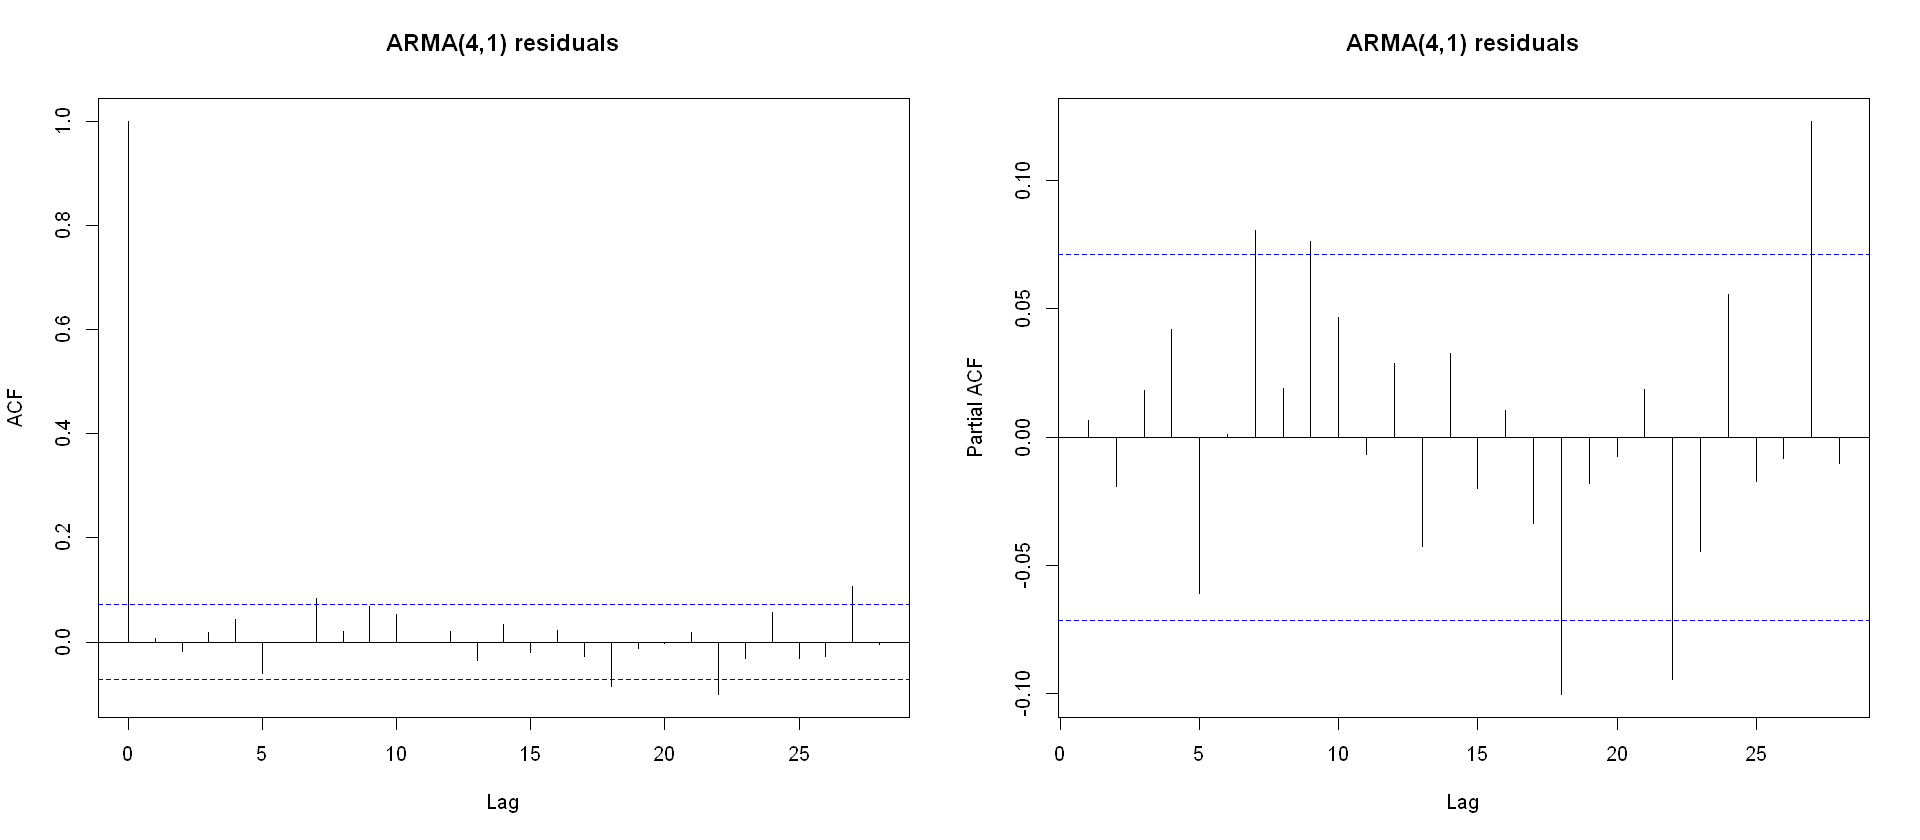

In [53]:
#ACF and PACF
par(mfrow=c(1,2))
options(repr.plot.width = 16, repr.plot.height = 7)
acf(arma41$residuals, main = "ARMA(4,1) residuals")
pacf(arma41$residuals, main = "ARMA(4,1) residuals")

#Ljung-Box test
for (lag_order in c(4, 8, 12)) {
    print(Box.test(arma41$residuals, type = "Ljung-Box", lag = lag_order))
}

As can be seen, this model does a much better job at removing the dependencies. The Ljung-Box test cannot reject the null of no autocorrelation even at the 12th order. The ACF does not show almost any significant correlation. There are still some dependencies left in the lags of the higher order according to PACF but we would likely need to increase the order of the ARMA process way too much to remove them. In addition, we should also consider that these correlations may be caused by the non-constant variance observed above which would need to be modelled with GARCH. This may explain the relatively poor performance of the ARMA(2,2) model. The perfect model may be the ARMA(2,2) used in conjuction with GARCH.